# Preparing dataset for SD fine-tunning

## 1. Cropping fast and cheap

We have provided a small sample of images to demonstrate how the cropping/annotation works:

In [1]:
from pathlib import Path
from yo_fluq_ds import *
from zoo.images import ConvertImage
from PIL import Image
import ipywidgets

basepath = Path('files/images')
image_path = basepath/'images'

(Query
 .folder(image_path)
 .where(lambda z: z.name.endswith('.png'))
 .select(Image.open)
 .select(lambda z: ConvertImage(z).resize(200,200).to_pywidget())
 .feed(lambda z: ipywidgets.HBox(children=list(z)))
)

To use the cropper, you need to install `pyqt5`

In [2]:
!pip install pyqt5

Then, you can run cropper in a folder that contains the images (uncomment the line to do this). Controls:

* Left-click - add/remove crop
* Mouse wheel - increase/decrease crop size
* Ctrl + mouse wheel - rotate
* Space - next image
* Ctrl-Space - previous image

In [3]:
from zoo.images.croper import run_croper

#run_croper(image_path)

Then, extract the images:

In [4]:
from zoo.images.extractor import Extractor

extractor = Extractor(image_path)
extractor.process_all()

  0%|          | 0/5 [00:00<?, ?it/s]

Let's preview the images. Yes, we know tht some of them are too similar, and this will be addressed later in this demo.

In [5]:
extractor.preview()

We can now save the results. We won't actually do it, as for the annotation we pre-created the folder with the extracted images and autoannotations

In [6]:
#extractor.save(basepath/'extraction_1')

## 2. Optimizations for Visual Novels

If you extract images from visual novels, you may have series of images with same backgrounds and poses, and small differences in faces or other parts. 

**If it's not your case, ignore this section***

Important: the sample images for these demos were created by merging sprites from visual novel. In the actual reality, you don't need to crop the images generated this way, you can simply generate them of already the right size. The series of images we are talking about mostly come from cutscenes. 

So if it's the case that you have the cuscenes and want to save some time, you may use the following procedure. 

In [7]:
from zoo.images.clusterizer import Clusterizer

clusterizer = Clusterizer(image_path)
clusterizer.compute()

  0%|          | 0/10 [00:00<?, ?it/s]

You can view the dendrogram to determine optimal cut height:

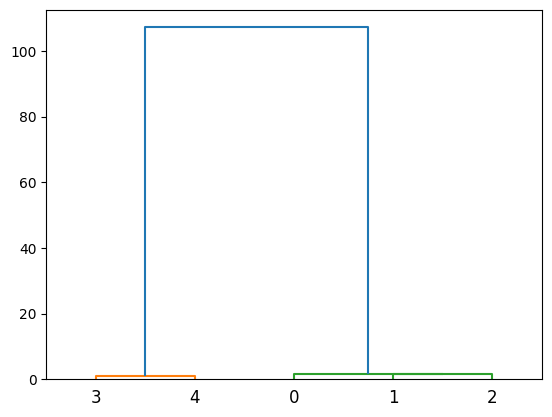

In [8]:
clusterizer.dendrogram()
pass

Then, cut the clusters at this height (e.g. 20), and preview the result:

In [9]:
clusterizer.cut(20)
clusterizer.preview()

Looks reasonable! Now we can save the result to some other folder:

In [10]:
cluster_path = basepath/'clusters'
clusterizer.save(cluster_path, overwrite = False)

In [11]:
Query.folder(cluster_path,'**/*').order_by(lambda z: z).to_list()

[WindowsPath('files/images/clusters/dv_1_cry.png'),
 WindowsPath('files/images/clusters/dv_1_cry.png.crop.json'),
 WindowsPath('files/images/clusters/dv_1_cry.png.group'),
 WindowsPath('files/images/clusters/dv_1_cry.png.group/dv_1_shocked.png'),
 WindowsPath('files/images/clusters/dv_1_cry.png.group/dv_1_surprise.png'),
 WindowsPath('files/images/clusters/dv_4_laugh.png'),
 WindowsPath('files/images/clusters/dv_4_laugh.png.crop.json'),
 WindowsPath('files/images/clusters/dv_4_laugh.png.group'),
 WindowsPath('files/images/clusters/dv_4_laugh.png.group/dv_4_smile.png')]

So we see that two images are in the root of the folder. Other images are placed inside directories with the names, linked to the cluster representatives.

Now we can run the cropper. The cropper will only proceed the representatives:

In [12]:
#run_croper(cluster_path)

Extractor will, as before, extract the images. But since some images are cropped from the non-changed parts of the images within cluster, we can now diversify:

In [13]:
extractor = Extractor(cluster_path)
extractor.process_all()
extractor.diversify()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
extractor.df[['originality','boredom']]

,originality,boredom
0,6.503642,0
2,6.503642,1
4,5.918750,2
3,0.060692,0
5,0.060692,1
1,0.008400,2
6,3.721100,0
8,3.721100,1
7,0.000000,0
9,0.000000,1


Originality means that this subimage is in some ways original, so it's different in some ways from the subimage of another image from the same cluster. Boredom indicate the ordinal of the subimage within the cluster. You can select the images you want on different criteria:

In [15]:
selection = extractor.df.loc[(extractor.df.originality>0.1) | (extractor.df.boredom==0)]
extractor.preview(selection)

In [16]:
#extractor.save(basepath/'extraction_2', selection)

## 3. Composing images from sprites

To extract data from `renpy`-based visual novel you will need to install `unrpa` package. This pachage will unpack the `rpa` files into normal png, jpg, etc.

Then, you can use something like this:

```
def make(back_path, body_path, cloth_path, face_path, dh):
    back = Image.open(back_path)
    body = Image.open(body_path)
    cloth = Image.open(cloth_path)
    face = Image.open(face_path)
    dx = (back.width-body.width)//2
    dy = (back.height-body.height)
    back.paste(body, (dx,dy), body)
    back.paste(cloth, (dx,dy), cloth)
    back.paste(face, (dx, dy), face)
    H = body.height-dh
    x0 = (back.width-H)//2
    y0 = back.height-H
    return back.crop((x0, y0, x0+H, y0+H))
```